In [8]:
# Import Required Packages
import torch
import os
import json
import sys
import re
import random
import importlib.util
from typing import *
from tqdm import tqdm 
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from JS_functions import *
from JS_Augmentaters import *

sys.path.append(os.path.abspath("re-arc"))
from dsl import *
from generators import *
from main import *
from utils import *
from verifiers import *

# Notebook

- Map percepetions to ReARC
- Augment Data with these invariances


In [9]:
list_perceptions_training = [ ["spatial-ordinal","replication"],
        "centroid",
        "replication",
        "motion",
        ["continuity", "replication"],
        "categorical",
        ["replication"],
        ["motion","categorical"],
        "topological",
        "size",
        "similarity",
        "replication",
        "continuity",
        "similarity",
        "replication",
        "symmetry",
        ["symmetry","replication"],
        "similarity",
        "replication",
        "symmetry",
        "quantitative",
        ["motion","depth"],
        ["similarity","topological"],
        ["continuity","depth"],
        "motion",
        "categorical",
        "symmetry",
        "continuity",
        "figure-ground",
        "spatial-ordinal",
        "figure-ground",
        "motion",
        "replication",
        "continuity",
        "continuity",
        "figure-ground",
        ["continuity","topological"],
        "quantitative",
        ["similarity","symmetry"],
        "spatial-ordinal",
        "closure",
        ["topological","motion"],
        "replication",
        ["motion","centroid"],
        "categorical",
        ["topological","depth"],
        ["continuity","depth"],
        "topological",
        "size",
        ["spatial-ordinal","closure"],
        "continuity",
        "spatial-orientation",
        "motion",
        ["replication","figure-ground"],
        "centroid",
        "figure-ground",
        "replication",
        "continuity",
        "quantitative",
        ["continuity","spatial-ordinal"],
        "replication",
        ["figure-ground","symmetry"],
        ["size","spatial-orientation"],
        ["topological","continuity"],
        "similarity",
        ["topological","continuity"],
        "similarity",
        "quantitative",
        "replication",
        "closure",
        "symmetry",
        "categorical",
        "motion",
        "symmetry",
        "replication",
        ["replication","spatial-orientation"],
        "closure",
        "motion",
        "quantitative",
        "replication",
        "closure",
        "continuity",
        ["replication","symmetry"],
        "continuity",
        "topological",
        ["similarity","replication"],
        "symmetry",
        ["figure-ground","centroid"],
        ["replication","categorical"],
        ["quantitative","closure"],
        ["closure","size"],
        ["spatial-orientation","closure"],
        "motion",
        ["centroid","depth"],
        ["replication"],
        ["motion","size"],
        "topological",
        "centroid",
        "closure",
        "size",
        "replication",
        ["centroid","topological"],
        "topological",
        "continuity",
        "closure",
        "symmetry",
        "continuity",
        "topological",
        ["replication","symmetry"],
        "replication",
        "figure-ground",
        "symmetry",
        "symmetry",
        ["It looks to be corrupt", "continuity","spatial-ordinal"],
        ["topological","spatial-ordinal"],
        "symmetry",
        "symmetry",
        "figure-ground",
        "continuity",
        "centroid",
        "figure-ground",
        ["motion","centroid"],
        "replication",
        "caching",
        "centroid",
        ["closure","motion"],
        "categorical",
        "motion",
        "quantitative",
        "figure-ground",
        ["motion","symmetry"],
        "closure",
        "similarity",
        ["similarity","figure-ground"],
        "spatial-ordinal",
        "continuity",
        ["centroid","closure"],
        ["similarity","continuity"],
        "closure",
        "symmetry",
        "continuity",
        "symmetry",
        "similarity",
        "categorical",
        "size",
        ["It looks to be corrupt", "I can't solve it"],
        "topological",
        ["categorical","continuity"],
        "quantitative",
        "symmetry"
        ]

print(len(list_perceptions_training))

150


In [10]:
# Set the desired working directory
os.chdir("/home/jdelinea/ARC-AGI/BARC")
directory_path = "reARC_tasks"

dic_training = create_arc_training_tasks(directory_path, list_perceptions_training)

print(len(dic_training))


150


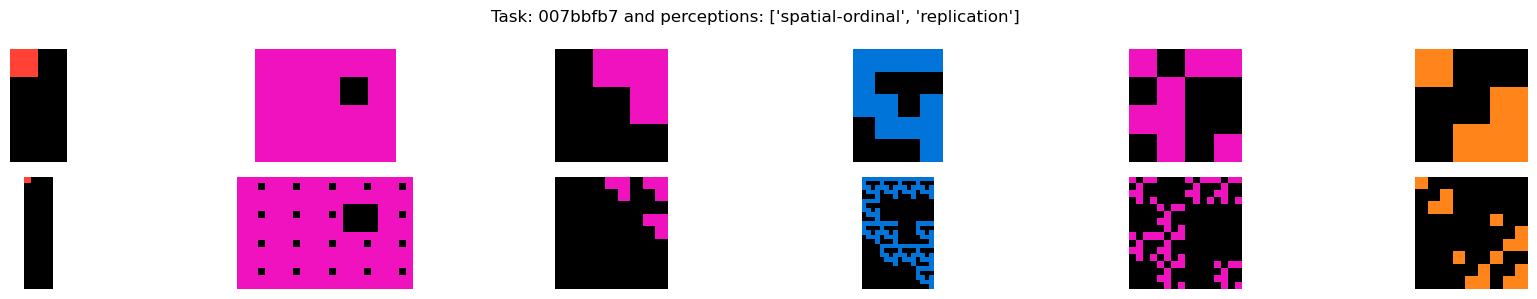

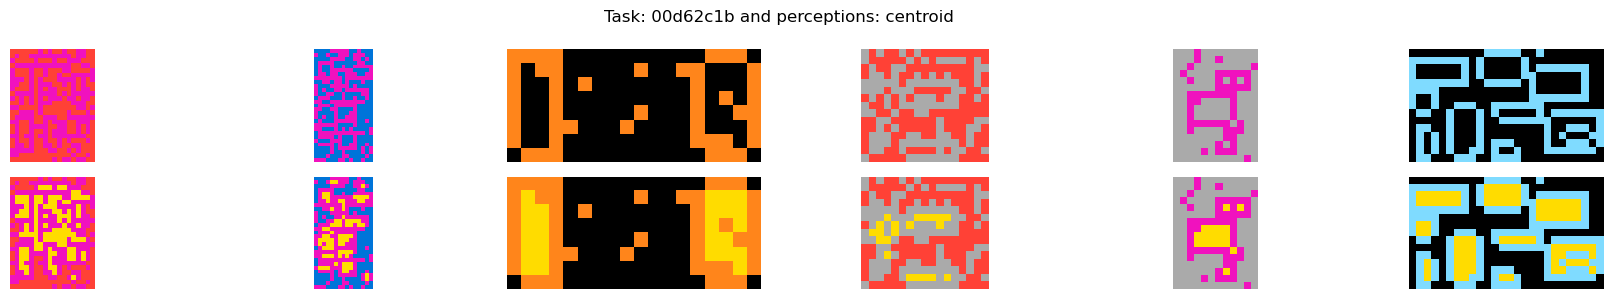

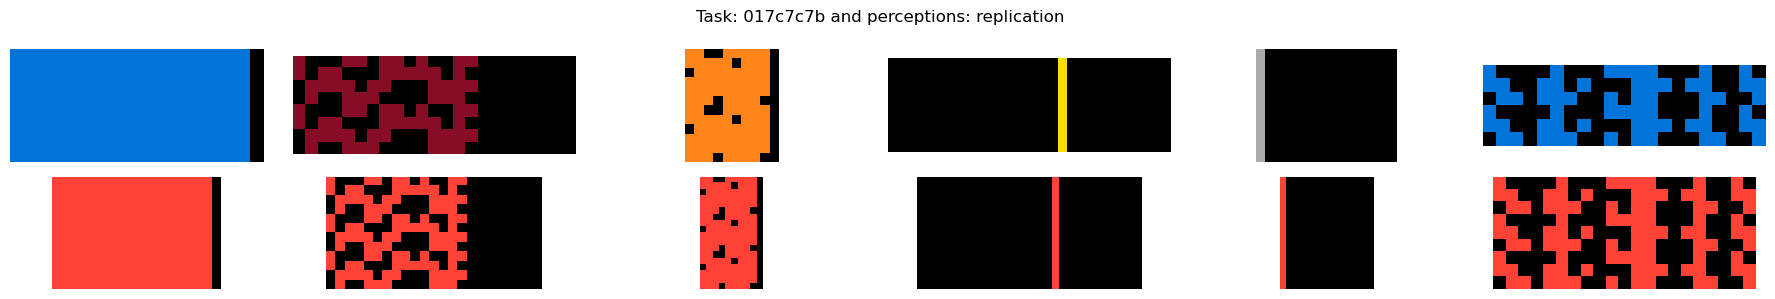

In [11]:
# Show Examples
for i, key in enumerate(dic_training):

    if i >=3:
        break
    
    dat = dic_training[key]["example"][0:6]
    name = dic_training[key]["name"]
    label = dic_training[key]["perceptions"]

    plot_arc_train_data(dat,name,label)

# Register Full Training
#with open("perceptions_training_full.json", "w") as f:
#    json.dump(dic_training,f )



In [12]:
def invariance_seeds(module, module_name, group_action_dict, max_attempts):
    invariance_results = []  # List to store invariance information for each attempt

    if hasattr(module, "generate_input") and hasattr(module, "main"):
        print(f"Running {module_name}...")

        for attempt in range(max_attempts):
            try:
                # Call the 'generate_input' function
                task_input = module.generate_input()
                # Call the 'main' function with the generated input
                result = module.main(task_input)

                # Dictionary to store invariance for this attempt
                attempt_invariance = {
                    "attempt": attempt + 1,
                    "input": task_input,
                    "result": result,
                    "invariance": {}
                }

                # Check each transformation in group_action_dict
                for action_name, group_action in group_action_dict.items():
                    try:
                        # Apply the transformation to the input
                        transformed_input = group_action(task_input)
                        # Apply the main function to the transformed input
                        transformed_result = module.main(transformed_input)

                        # Check if the transformation maintains invariance
                        if transformed_result == group_action(result):
                            attempt_invariance["invariance"][action_name] = True
                        else:
                            attempt_invariance["invariance"][action_name] = False
                    except Exception as e:
                        attempt_invariance["invariance"][action_name] = f"Error: {e}"

                # Add the invariance results for this attempt to the list
                invariance_results.append(attempt_invariance)

            except Exception as e:
                print(f"Attempt {attempt + 1}: Error - {e}")

        # Print summary of invariance results
        for result in invariance_results:
            print(f"\nAttempt {result['attempt']}:")
            print(f"Input: {result['input']}")
            print(f"Result: {result['result']}")
            for action, is_invariant in result['invariance'].items():
                print(f"  {action}: {'Invariant' if is_invariant is True else is_invariant}")

    else:
        print(f"{module_name} does not contain 'generate_input' or 'main' functions.\n")

    return invariance_results


In [13]:
# Create a dictionary with descriptive names as keys and augmenter instances as values
group_action_dict = {
    "Rotate 90°": Rotate(90),
    "Rotate 180°": Rotate(180),
    "Rotate 270°": Rotate(270),
    "Flip Vertical": Flip(axis=0),
    "Flip Horizontal": Flip(axis=1),
    "Permute Colors": PermuteColors(),
    "Dropout": Dropout(),
}

In [34]:
def list_to_tuple(nested_list):
    return tuple(tuple(row) for row in nested_list)

In [43]:
x = dic_training["007bbfb7"]["example"]

verifiers = get_verifiers()
verifier = verifiers["007bbfb7"]

k = list_to_tuple(x[0]["input"])

print(verifier(k) == list_to_tuple(x[0]["output"]) )

True


In [47]:
for action_name, group_action in group_action_dict.items():
    print(group_action)


Rotate 90°
Rotate 180°
Rotate 270°
Flip Vertical
Flip Horizontal
Permute Colors
Dropout


We will check

$$
\phi \circ \alpha_g(x) = \alpha_g \circ \phi_T(x) \quad \text{equiv} \quad \phi(\alpha_g(x)) = \alpha_g(y)
$$

In [50]:
dict_invariances = {}

verifiers = get_verifiers()

for key in dic_training:

    # Import phi_T
    phi_T = verifiers[key]
    
    # Usually 1000
    for j in range(len(dic_training[key]["example"])):

        # I also have to change into tuple to use the function from reARC
        x = list_to_tuple(dic_training[key]["example"][j]["input"])
        y = list_to_tuple(dic_training[key]["example"][j]["output"])

        #print(phi_T(x) == y)

        for action_name, group_action in group_action_dict.items():
                
                print( phi_T(group_action(np.array(x))) == list_to_tuple(group_action(np.array(y))) )




ValueError: too many values to unpack (expected 2)

In [ ]:
    for action_name, group_action in group_action_dict.items():

        n = len(dic_training[key]["example"])

        # We will attribuate an equivariance score to each transformations
        for i in range(n):



    dict_invariances[key] = {
        "name": dic_training[key]["name"],
        "perceptions": dic_training[key]["perceptions"]
    }
    